# Notebook élaboration du modèle de classification

Dans le cadre du projet 7 Open_Classrooms, ce notebook a pour but d'établir le modèle de ML le plus performant possible dans le but de classifier les clients en "accord de prêt bancaire" ou "refus de prêt bancaire".


### Import des fonctions

In [23]:
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import json

import numpy
import sklearn.metrics

# Load packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neighbors import NearestNeighbors

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Modèles de ML

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet

color = sns.color_palette()

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


from sklearn.decomposition import PCA
from functionsp7 import *
import pickle


### Récupération du dataset prétraité

Les dataset suivants ont été obtenus dans le premier notebook de preprocessing et d'analyse exploratoire, qui est un kernel kaggle.

In [25]:
data_train = pd.read_csv("data_train_preprocessed.csv")
#data train WITHOUT TARGET that has been saved in the following file


target = pd.read_csv("column_target")
# series of targets assossiated with previous files

data_test = pd.read_csv("data_test_preprocessed.csv")
# data test. given by kaggle to evaluated the model of the competitors. has no target value. This dataset is the one of which the clients are point of interest in our project, and that will appear in the final dashboard.




In [26]:
print(data_train.shape, data_test.shape)
# check shape of datasets

(307511, 240) (48744, 240)


In [27]:
data_train.insert(loc=1, column = 'TARGET', value = target)
# insert target column in the Train dataset

In [28]:
data = data_train
data.head(20)
# check the dataset

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0.0,0.0,1.0,0.000000,0.001512,0.090287,0.090032,0.077441,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,100003,0,0.0,0.0,0.0,0.000000,0.002089,0.311736,0.132924,0.271605,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100004,0,1.0,1.0,1.0,0.000000,0.000358,0.022472,0.020025,0.023569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0.0,0.0,1.0,0.000000,0.000935,0.066837,0.109477,0.063973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0.0,0.0,1.0,0.000000,0.000819,0.116854,0.078975,0.117845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,0.0,0.0,1.0,0.000000,0.000627,0.111235,0.101018,0.103255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,0.0,1.0,1.0,0.052632,0.001243,0.378458,0.154774,0.337823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010,0,0.0,1.0,1.0,0.000000,0.002858,0.370787,0.157792,0.371493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,0.0,0.0,1.0,0.000000,0.000742,0.243348,0.125623,0.217733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,1.0,0.0,1.0,0.000000,0.000935,0.089888,0.072675,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
data = data.drop(["SK_ID_CURR"], axis=1)
# Remove the column ID that is not a feature for the project. this is just what identifies the client.

### Equilibrage des données

Voyons si le jeu de données est équilibré selon la variable binaire TARGET
Rappel :
0 = remboursement
1 = défaut de paiement

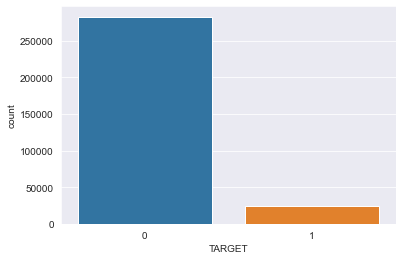

In [30]:
sns.countplot(x='TARGET', data=data)
plt.show()

In [31]:
data["TARGET"].value_counts()/len(data)*100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

92% des échantillions du train set sont dans la catégorie 0.
Le dataset est donc déséquilibré.
Il convient de le rééquilibrer avant l'entrainement pour améliorer les performances des modèles de ML

Cela sera fait grâce aux transformeurs SMOTE (qui ajoute des échantillons à la catégorie minoritaire) et RandomUnderSampler (qui retire des échantillons à la catégorie majoritaire)

Cette étape se fera dans le grid search CV sur la pipeline complète. En effet, les paramètres de SMOTE et RandomUnderSampler seront aussi soumis à une recherche pour trouver leur valeurs optimales.

In [32]:
X = data.drop(labels=["TARGET"], axis=1, inplace=False)
y = data["TARGET"]
# Implementation of X and y for machine learning

In [33]:
X.std()
# Check if there is no absurd values on std of variables

NAME_CONTRACT_TYPE                 0.293509
FLAG_OWN_CAR                       0.473746
FLAG_OWN_REALTY                    0.460968
CNT_CHILDREN                       0.038006
AMT_INCOME_TOTAL                   0.002027
                                     ...   
WALLSMATERIAL_MODE_Stone, brick    0.407858
WALLSMATERIAL_MODE_Wooden          0.130892
EMERGENCYSTATE_MODE_No             0.499660
EMERGENCYSTATE_MODE_Yes            0.086679
DAYS_EMPLOYED_ANOM                 0.384248
Length: 239, dtype: float64

### PCA

Le dataset contenant 240 variables, il est préférable de le réduire par PCA afin de rendre plus rapide les entrainements de modèles.

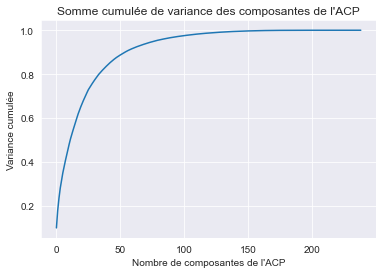

In [36]:
pca = PCA()

pca.fit(X)

plt.figure()
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(pca.explained_variance_ratio_.shape[0])),
         np.cumsum(pca.explained_variance_ratio_))
plt.show()

Afin de conserver 80% de la variance, nous garderons 30 variables sur les 240 variables.

L'étape de transformation sera effectuée plus bas dans la pipeline, après l'équilibrage du dataset et avant le modèle de classification

## Entrainement des modèles

### Différents modèles à tester

Dans cette partie je précise les différents modèles qui seront testés, ainsi que les paramètres à optimiser associés.

In [14]:
# parameters grid for logistic regression
params_logistic_reg = {"classification__C" : np.logspace(-2,2,5)}

# parameters grid for random forest classifier
params_random_forest = {"classification__n_estimators" : [10,50,100,200]}

# parameters grid for XGBoost
params_xgboos = {"classification__n_estimators" : [10,50,100,200]}


# dict of classifiers
dct_classifiers = {'Dummy Classifier': [DummyClassifier(), None],
                   'Logistic Regression': [LogisticRegression(),params_logistic_reg],
                   'Random Forest': [RandomForestClassifier(n_estimators=100),params_random_forest],
                   'Xgboost': [GradientBoostingClassifier(),params_xgboos]
                   }





### Définition du score du grid search

Pour tester les performances de nos modèles, un score personnalisé a été implémenté dans le fichier functionsp7.py (voir note méthodologique)

il faut transofmer cet objet "fonction" en objet "score" pour l'utiliser dans un grid search, grâce à la fonction "make_scorer" de sklearn.

In [40]:
#Implement the scorer

from sklearn.metrics import make_scorer
from functionsp7 import custom_score_fct

custom_score = make_scorer(custom_score_fct, greater_is_better= True)
# custom_score_fct is a custom function

In [41]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import time

In [42]:
n_frac = len(X) # in case i want to decrease samples to increase speed for tests
X_train, X_test, y_train, y_test = train_test_split(X[:n_frac], y[:n_frac], test_size=0.2, random_state=42)

# list of scores for each classification model
list_scores = []

# list of best estimator of grid search for each model
list_best_estimators = []


### Entraînement du Dummy Classifier

In [19]:
model_dummy = DummyClassifier()

start_time = time.time()

param_grid = {
    "over_sampling__sampling_strategy" : np.linspace(0.1,0.5,4),
    "under_sampling__sampling_strategy" : np.linspace(0.1,0.5,4)
}

pca = PCA(n_components = 30)  #90% of explained variance

over_sampling = SMOTE()
under_sampling = RandomUnderSampler()

steps = [('over_sampling', over_sampling), ('under_sampling', under_sampling),
         ("pca", pca),
         ('classification', model_dummy)]

model_pipeline = Pipeline(steps=steps)

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

grid_search_dummy = GridSearchCV(estimator=model_pipeline,
                           param_grid=param_grid,
                           scoring=custom_score,
                           cv=stratified_kfold,
                           n_jobs=1,
                           verbose = 2)

grid_search_dummy.fit(X_train, y_train)

cv_score = grid_search_dummy.best_score_
list_scores.append(cv_score)
list_best_estimators.append(grid_search_dummy.best_estimator_)
test_score = grid_search_dummy.score(X_test, y_test)


print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("time taken : %s seconds" % (time.time() - start_time))
print("\n -------  \n")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  16.8s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  17.7s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  17.7s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  12.1s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  10.9s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  10.4s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.3666666666666667; total time=   9.5s
[CV] END over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.3666666666666667; total time=   9.4s
[CV] END over_samplin

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\simon

Cross-validation score: 0.0
Test score: 0.0
time taken : 563.690943479538 seconds

 -------  



### Entraînement de la Régression Logistique

In [20]:
model_logreg = LogisticRegression()

start_time = time.time()

param_grid = {
    "over_sampling__sampling_strategy" : np.linspace(0.1,0.5,4),
    "under_sampling__sampling_strategy" : np.linspace(0.1,0.5,4)
}

pca = PCA(n_components = 30)  #90% of explained variance

over_sampling = SMOTE()
under_sampling = RandomUnderSampler()

steps = [('over_sampling', over_sampling), ('under_sampling', under_sampling),
         ("pca", pca),
         ('classification', model_logreg)]

param_grid.update(params_logistic_reg) #Concacenate 2 dicts

model_pipeline = Pipeline(steps=steps)

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

grid_search_logreg = GridSearchCV(estimator=model_pipeline,
                                 param_grid=param_grid,
                                 scoring=custom_score,
                                 cv=stratified_kfold,
                                 n_jobs=1,
                                 verbose = 2)

grid_search_logreg.fit(X_train, y_train)

cv_score = grid_search_logreg.best_score_
list_scores.append(cv_score)
list_best_estimators.append(grid_search_logreg.best_estimator_)
test_score = grid_search_logreg.score(X_test, y_test)


print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("time taken : %s seconds" % (time.time() - start_time))
print("\n -------  \n")

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  11.6s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  10.8s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  10.8s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=   8.7s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=   8.4s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=   8.4s
[CV] END classification__C=0.01, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.366666666

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\simo

Cross-validation score: 0.04970709565511731
Test score: 0.04837474006785597
time taken : 2335.7592947483063 seconds

 -------  



### Entraînement de Random Forest Classifier

In [21]:
model_rf = RandomForestClassifier()

start_time = time.time()

param_grid = {
    "over_sampling__sampling_strategy" : np.linspace(0.1,0.5,4),
    "under_sampling__sampling_strategy" : np.linspace(0.1,0.5,4)
}

pca = PCA(n_components = 30)  #90% of explained variance

over_sampling = SMOTE()
under_sampling = RandomUnderSampler()

steps = [('over_sampling', over_sampling), ('under_sampling', under_sampling),
         ("pca", pca),
         ('classification', model_rf)]

param_grid.update(params_random_forest) #Concacenate 2 dicts

model_pipeline = Pipeline(steps=steps)

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

grid_search_rf = GridSearchCV(estimator=model_pipeline,
                                  param_grid=param_grid,
                                  scoring=custom_score,
                                  cv=stratified_kfold,
                                  n_jobs=1,
                                  verbose = 2)

grid_search_rf.fit(X_train, y_train)

cv_score = grid_search_rf.best_score_
list_scores.append(cv_score)
list_best_estimators.append(grid_search_rf.best_estimator_)
test_score = grid_search_rf.score(X_test, y_test)

#
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("time taken : %s seconds" % (time.time() - start_time))
print("\n -------  \n")

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  32.3s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  26.7s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  26.5s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  15.1s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  14.5s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  14.6s
[CV] END classification__n_estimators=10, over_sampling__sampl

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\simo

Cross-validation score: 0.04031077971677514
Test score: 0.043495552066980636
time taken : 36739.74182724953 seconds

 -------  



### Entrainement de Gradient Boosting Classifier

In [19]:
model_gb = GradientBoostingClassifier()

start_time = time.time()

param_grid = {
    "over_sampling__sampling_strategy" : np.linspace(0.1,0.5,4),
    "under_sampling__sampling_strategy" : np.linspace(0.1,0.5,4)
}

pca = PCA(n_components = 30)  #90% of explained variance

over_sampling = SMOTE()
under_sampling = RandomUnderSampler()

steps = [('over_sampling', over_sampling), ('under_sampling', under_sampling),
         ("pca", pca),
         ('classification', model_gb)]

param_grid.update(params_xgboos) #Concacenate 2 dicts

model_pipeline = Pipeline(steps=steps)

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

grid_search_gb = GridSearchCV(estimator=model_pipeline,
                              param_grid=param_grid,
                              scoring=custom_score,
                              cv=stratified_kfold,
                              n_jobs=1,
                              verbose = 2)

grid_search_gb.fit(X_train, y_train)

cv_score = grid_search_gb.best_score_
list_scores.append(cv_score)
list_best_estimators.append(grid_search_gb.best_estimator_)
test_score = grid_search_gb.score(X_test, y_test)


print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("time taken : %s seconds" % (time.time() - start_time))
print("\n -------  \n")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  37.5s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  38.7s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.1; total time=  33.3s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  18.0s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  18.5s
[CV] END classification__n_estimators=10, over_sampling__sampling_strategy=0.1, under_sampling__sampling_strategy=0.23333333333333334; total time=  17.7s
[CV] END classification__n_estimators=10, over_sampling__sampl

C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
72 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\simon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\simon\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\simo

Cross-validation score: 0.04292088789895051
Test score: 0.04318718823838278
time taken : 20861.49769473076 seconds

 -------  



### Enregistrements des modèles

In [20]:
pickle.dump(grid_search_gb, open("modele_gb", "wb"))

In [24]:
pickle.dump(grid_search_dummy, open("modele_dummy", "wb"))
pickle.dump(grid_search_logreg, open("modele_logreg", "wb"))
pickle.dump(grid_search_rf, open("modele_rf", "wb"))

### Exploration des modèles entrainés et Selection du meilleur modèle

In [19]:
sModel_dummy = pickle.load(open("modele_dummy", 'rb'))
sModel_lr = pickle.load(open("modele_logreg", 'rb'))
sModel_gb  = pickle.load(open("modele_gb", 'rb'))
sModel_rf = pickle.load(open("modele_rf", 'rb'))

In [20]:
# y_pred for each model

y_pred_dummy = sModel_dummy.predict(X_test)
y_pred_lr = sModel_lr.predict(X_test)
y_pred_rf = sModel_gb.predict(X_test)
y_pred_gb = sModel_rf.predict(X_test)

In [23]:
print(sModel_dummy.score(X_test,y_test))
print(sModel_lr.score(X_test,y_test))
print(sModel_rf.score(X_test,y_test))
print(sModel_gb.score(X_test,y_test))

# this is the custom_f1_score

0.0
0.04837474006785597
0.043495552066980636
0.04318718823838278


Le modèle ayant le meilleur score custom_f1 est la Régression Logistique.
Le modèle Dummy a, comme prévu, un score de 0. En effet le f1 score du dummy classifier est toujours 0 car il classe tous les éléments dans la classe majoritaire.

Le custom_f1 est aussi 0 car il n'y a que le dénominateur de la formule qui change (par rapport aux taux de faux positifs, faux négatifs, etc.)


In [24]:
print(sModel_dummy.best_estimator_.score(X_test,y_test))
print(sModel_lr.best_estimator_.score(X_test,y_test))
print(sModel_rf.best_estimator_.score(X_test,y_test))
print(sModel_gb.best_estimator_.score(X_test,y_test))

# this is the accuracy score

0.9195323805342829
0.8556330585499894
0.8291628050664195
0.8686893322276962


On constate que les modèles entrainés présentent tous de moins bons score d' accuracy que le dummy classifier. Ce n'est pas anormal pour de la classification binaire déséquilibrée. Cela est du au score que j'ai défini qui force le modèle a effectuer un plus grand nombre d'erreurs de faux positifs, du moment que l'on en fait moins dans les faux négatifs.

In [25]:
print(roc_auc_score(y_test,y_pred_dummy))
print(roc_auc_score(y_test,y_pred_lr))
print(roc_auc_score(y_test,y_pred_rf))
print(roc_auc_score(y_test,y_pred_gb))

0.5
0.5671237380555993
0.5633447978447605
0.5466459142224414


le AUC score demeure faible. Les points d'amélioration sont détaillés dans la note méthodologique du projet.

In [26]:
# Parameters of best model
sModel_lr.best_params_

{'classification__C': 1.0,
 'over_sampling__sampling_strategy': 0.3666666666666667,
 'under_sampling__sampling_strategy': 0.5}

### Affinage du meilleur modèle trouvé

Le meilleur modèle est défini comme la régression logistique avec comme paramètre C = 1.

Je vais maintenant affiner la recherche du meilleur paramètre C en centrant le grid search autour de la valeur 1.

In [27]:
model_logreg2 = LogisticRegression()

precise_grid_LR = {"classification__C" : np.linspace(0.2,5,30)}

pca = PCA(n_components = 30)  #90% of explained variance

over_sampling = SMOTE(sampling_strategy=0.36667)
under_sampling = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over_sampling', over_sampling), ('under_sampling', under_sampling),
         ("pca", pca),
         ('classification', model_logreg2)]



model_pipeline = Pipeline(steps=steps)

stratified_kfold = StratifiedKFold(n_splits=3,
                                   shuffle=True,
                                   random_state=11)

grid_search_logreg_precise = GridSearchCV(estimator=model_pipeline,
                                  param_grid=precise_grid_LR,
                                  scoring=custom_score,
                                  cv=stratified_kfold,
                                  n_jobs=1,
                                  verbose = 2)

grid_search_logreg_precise.fit(X_train, y_train)

cv_score = grid_search_logreg_precise.best_score_
test_score = grid_search_logreg_precise.score(X_test, y_test)

#
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print("\n -------  \n")



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ..............................classification__C=0.2; total time=  12.8s
[CV] END ..............................classification__C=0.2; total time=  13.4s
[CV] END ..............................classification__C=0.2; total time=  11.7s
[CV] END ..............classification__C=0.36551724137931035; total time=  11.3s
[CV] END ..............classification__C=0.36551724137931035; total time=  11.4s
[CV] END ..............classification__C=0.36551724137931035; total time=  10.9s
[CV] END ...............classification__C=0.5310344827586206; total time=  11.0s
[CV] END ...............classification__C=0.5310344827586206; total time=  10.9s
[CV] END ...............classification__C=0.5310344827586206; total time=  11.4s
[CV] END ...............classification__C=0.6965517241379311; total time=  11.2s
[CV] END ...............classification__C=0.6965517241379311; total time=  11.1s
[CV] END ...............classification__C=0.6965

In [31]:
grid_search_logreg_precise.best_estimator_
# New best parameter

Pipeline(steps=[('over_sampling', SMOTE(sampling_strategy=0.36667)),
                ('under_sampling', RandomUnderSampler(sampling_strategy=0.5)),
                ('pca', PCA(n_components=30)),
                ('classification', LogisticRegression(C=1.5241379310344827))])

Le nouveau paramètre optimal C trouvé est C = 1.52

### Enregistrement du modèle final

In [32]:
pickle.dump(grid_search_logreg_precise.best_estimator_, open("modele_LR_precise", "wb"))

In [44]:
model_final = pickle.load(open("modele_LR_precise", "rb"))

### Explicabilité locale du modèle

Cette section a pour but de développer les outils pour expliquer localement le modèle, c'est à dire, pour une instance du dataset donnée (un client), pouvoir déterminer quelles sont les variables qui ont le plus joué dans la prédiction.

J'utilise la librairie LIME pour l'explicabilité locale

In [45]:
import lime
from lime import lime_tabular

# explainer qui contient des informations générales sur le dataset
explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode = "classification", class_names=None, feature_names=X_train.columns.to_list())

# Enregistrement de l'explainer pour utilisation dans API de prédiction
import dill
with open('explainer_file', 'wb') as f:
    dill.dump(explainer, f)

In [46]:
# Test explainer pour une instance
explanation = explainer.explain_instance(X_train.iloc[2], model_final.predict_proba,
                                         num_features=20)

explanation.as_list()

C:\Users\simon\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


[('0.00 < FLAG_OWN_CAR <= 1.00', -0.07848923901080793),
 ('OCCUPATION_TYPE_Sales staff <= 0.00', -0.07829468356343469),
 ('ORGANIZATION_TYPE_Business Entity Type 3 <= 0.00', -0.0715262034508295),
 ('NAME_CONTRACT_TYPE <= 0.00', 0.07044446789629223),
 ('REGION_RATING_CLIENT_W_CITY <= 0.50', -0.06195928649041892),
 ('REGION_RATING_CLIENT <= 0.50', -0.06153455581313345),
 ('FLAG_DOCUMENT_3 <= 0.00', -0.05490961838296302),
 ('REG_CITY_NOT_LIVE_CITY <= 0.00', -0.05101326522619134),
 ('CODE_GENDER_F <= 0.00', 0.05048326965244151),
 ('0.00 < CODE_GENDER_M <= 1.00', 0.04942968962199734),
 ('ORGANIZATION_TYPE_Self-employed > 0.00', 0.04868453429120577),
 ('FLAG_PHONE <= 0.00', 0.04682402194756624),
 ('NAME_EDUCATION_TYPE_Higher education <= 0.00', 0.04579562761485298),
 ('NAME_EDUCATION_TYPE_Secondary / secondary special <= 0.00',
  -0.04143097869762007),
 ('NAME_FAMILY_STATUS_Single / not married <= 0.00', -0.035382669637389515),
 ('0.00 < FLAG_OWN_REALTY <= 1.00', 0.03470280172605276),
 ('OCC

### Selection de la valeur seuil pour classification

Cette section a pour but de déterminer à partir de quelle probabilité de remboursement un client se verra accorder un prêt.

Pour cela, je vais pour chaque valeur de probabilité seuil, calculer la classe de chaque client, puis évaluer le score custom_f1 entre le résultat et les données réelles.

La valeur seuil optimale sera celle pour laquelle le custom_f1 score est le plus élevé (cf note méthodologique)

In [52]:
y_pred_proba = model_final.predict_proba(X_test)
scores = []
thresholds = np.linspace(0,1,30)
for i in thresholds:
    y_class_pred = proba_to_class(y_pred_proba,i)
    scores.append(custom_score_fct(y_test,y_class_pred))


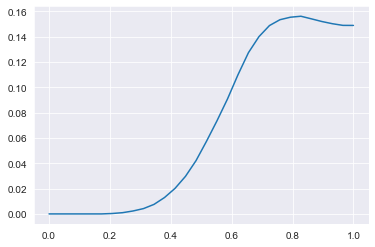

In [53]:
plt.plot(thresholds,scores)
plt.show()

In [54]:
thresholds[np.argmax(scores)]

0.8275862068965517

Conclusion : La valeur seuil optimale sera 82.7 %, arrondi à 80% pour améliorer l'explicabilité au client.

### Explicabilité globale du modèle

Cette section a pour but de déterminer l'explicabilité globale du modèle, c'est à dire déterminer quelles variables le modèle considère comme plus importantes à prendre en compte de manière globale. La méthode est expliquée dans la note méthodologique.
Les coefficients associés aux variables sont obtenus par multiplication matricielle des coefficients du modèles et des coefficients de la PCA.

In [50]:
# get_feature_importance is a custom function. gives the coefficients of importance of each feature of the dataset, considering a model (pipeline with pca and classification).
global_feat_importance = get_feature_importance(pipe_model = model_final, list_features= X_train.columns.to_list())
global_feat_importance
# feature sorted by order in original dataset

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,-0.363392,-0.413119,0.180512,0.003165,-0.000468,-0.023935,-0.005348,-0.028844,-0.236587,-0.167745,...,-0.029857,-0.006017,-0.012742,-0.00422,-0.058407,0.027744,0.009864,-0.100387,0.002634,-0.022396


In [51]:
# features sorted by absolute value to see the most important and their contribution (positive or negative)

feature_importance_sorted = global_feat_importance.iloc[0].reindex(global_feat_importance.iloc[0].abs().sort_values(ascending=False).index)

feature_importance_sorted

REGION_RATING_CLIENT           4.805867e-01
REGION_RATING_CLIENT_W_CITY    4.697936e-01
FLAG_OWN_CAR                  -4.131190e-01
OCCUPATION_TYPE_Sales staff    3.904900e-01
NAME_CONTRACT_TYPE            -3.633924e-01
                                   ...     
AMT_REQ_CREDIT_BUREAU_DAY      2.141052e-05
FLAG_DOCUMENT_12              -1.981216e-05
FLAG_DOCUMENT_10              -9.624048e-06
NAME_TYPE_SUITE_Other_A       -4.555568e-07
FLAG_MOBIL                    -3.551436e-08
Name: 0, Length: 239, dtype: float64

In [ ]:
# save the global feature importance
feature_importance_sorted.to_csv("global_feature_importance_sorted.csv", index=False)